<h1><center>01 Obstacle avoidance</center></h1>

<center><img src='images/logo.jpg' style="height:400px;"></center>

# Index
- [1. Robot platform](#section_1)
- [2. ROS](#section_2)
- [3. Foxglove](#section_3)
- [4. Setup environment](#section_4)
- [5. Obstacle avoidance](#section_5)
- [6. Simulator](#section_6)
- [7. Even simple](#section_7)
- [8. Wrap up](#section_8)


<a id='section_1'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>1</span>
        &nbsp;
        <span class=''>Robot platform</span>
    </h2>
</div>


* Edge devices IoT Raspberrypi 5 (Nvidia Jetson Isaac)
    * Platform specific
    * Headless

<center><img src='images/nvidia.jpg' style="height:600px;"></center>


* Real robot
    * Control board
    * Motor driver
    * Motor wheel
    * Distance sensor

<center><img src='images/circuit.jpg' style="height:600px;"></center>

<a id='section_2'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>2</span>
        &nbsp;
        <span class=''>ROS</span>
    </h2>
</div>


* ROS
    * UAV, ACC


<a id='section_3'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>3</span>
        &nbsp;
        <span class=''>Foxglove</span>
    </h2>
</div>


* Foxglove
    * Cloud


<a id='section_4'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>4</span>
        &nbsp;
        <span class=''>Setup environment</span>
    </h2>
</div>


1. **Install ROS packages**


```bash
    mkdir -p ~/ros2_ws/src
    cd ~/ros2_ws/src
    git clone https://github.com/onidzelskyi/ros2_ws.git 
    cd ~/ros2_ws
    rosdep install -i --from-path src --rosdistro jazzy -y
    colcon build --packages-select ultrasonic obstacle_avoidance motor_driver
```


2. **Connect to Foxglove via rosbridge websocket**

    Run in Terminal 1

```bash
    ros2 launch rosbridge_server rosbridge_websocket_launch.xml
```

3. **Turn on robot**


4. **Run ROS ultrasonic distance sensor**

   Run in Terminal 2

```bash
    ros2 run ultrasonic ultrasonic_publisher
```

    Watch logs

```bash
    ros2 topic echo /ultrasonic_range 

    header:
        stamp:
            sec: 1738680084
            nanosec: 99833274
        frame_id: ultrasonic_sensor
    radiation_type: 0
    field_of_view: 0.10000000149011612
    min_range: 0.019999999552965164
    max_range: 1.8154675960540771
    range: 1.821069359779358
    variance: 0.0
    ---    
```

    Visualize via Foxglove plot panel

```/ultrasonic_range.range```
```/ultrasonic_range.max_range```



5. **Run ROS obstacle avoidance node**

   Run in Terminal 3

```bash
    ros2 run obstacle_avoidance laser_obstacle_avoidance
```

    Watch logs

```bash
    ros2 topic echo /cmd_vel
    linear:
      x: 0.0
      y: 0.0
      z: 0.0
    angular:
      x: 0.0
      y: 0.0
      z: 0.5
    ---    
```

    Visualize via Foxglove plot panel

```/cmd_vel.linear.x```
```/cmd_vel_smooth.linear.x```

```/cmd_vel.angular.z```
```/cmd_vel_smooth.angular.z```


6. **Run ROS motor driver**

   Run in Terminal 4

```bash
    ros2 run motor_driver cmd_vel_subscriber 
```


7. **Camera view**

   Run in Terminal 5

```bash
    vlc rtsp://192.168.1.37/live/ch00_1
```



<a id='section_5'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>5</span>
        &nbsp;
        <span class=''>Obstacle avoidance</span>
    </h2>
</div>

Teach robot to navigate its immediate vicinity (e.g collision avoidance).

### Smooth velocity control by logarithm 

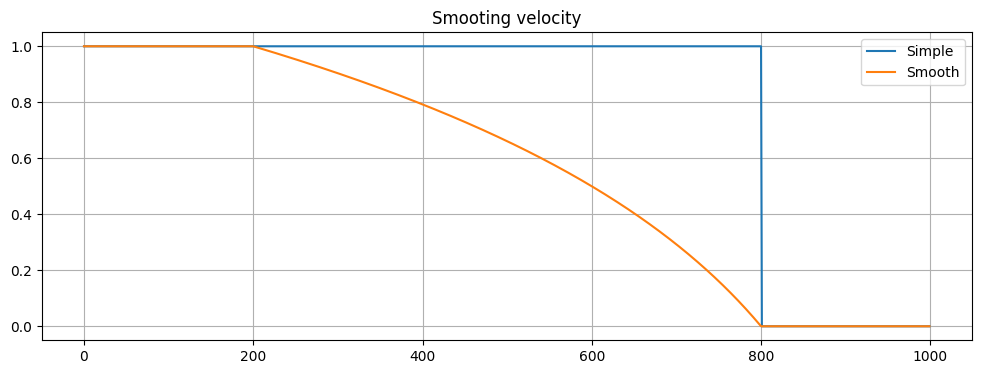

In [33]:
"""

<Robot> .......< A >..........< B >..........< Wall >


max linear velocity to point A
decrease linear velocity from A to B
zero linear velocity at point B
"""
import numpy as np
import matplotlib.pyplot as plt


min_vel = .0
max_vel = 1.
min_distance = 20
max_distance = 80

distance = np.arange(100, 0, -.1)
vel = np.ones(1000) * max_vel

for i, x in enumerate(distance):
    if x > max_distance: continue
    if x < min_distance: vel[i] = min_vel
    else:
        vel[i] = (np.log(x) - np.log(min_distance)) / (np.log(max_distance) - np.log(min_distance))
    
vel_simple = (distance > min_distance) * max_vel

plt.figure(figsize=(12, 4))
plt.plot(vel_simple, label='Simple')
plt.plot(vel, label='Smooth')
plt.legend()
plt.grid()
plt.title('Smooting velocity')
plt.show()

### Smooth distance measurements by Kalman filter 

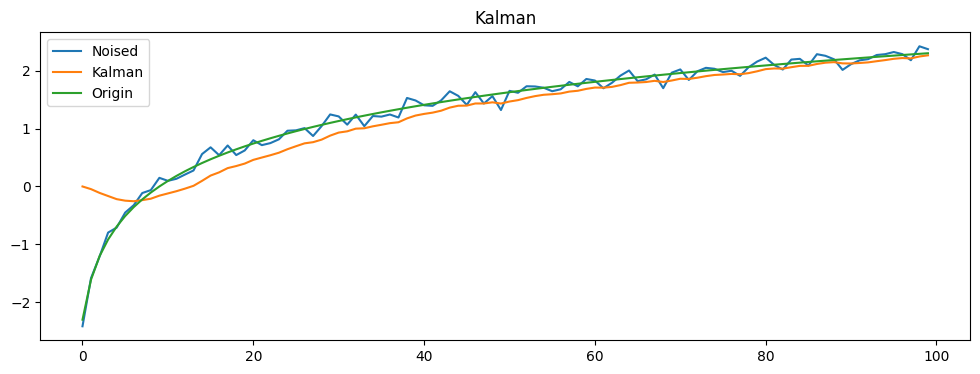

In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


kalman = cv.KalmanFilter(2, 1)
kalman.measurementMatrix = np.array([[1, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

samples = 100
o_arr = np.linspace(.1, 10, samples)
o_arr = np.log(o_arr)
n_arr = o_arr + np.random.normal(0, .1, samples)

f_arr = []

for x in n_arr:
    ekf = np.array([x], dtype=np.float32)
    kalman.correct(ekf)
    prediction = kalman.predict()
    f_arr.append(prediction[0][0])


plt.figure(figsize=(12, 4))
plt.plot(n_arr, label='Noised')
plt.plot(f_arr, label='Kalman')
plt.plot(o_arr, label='Origin')
plt.legend()
plt.title('Kalman')
plt.show()

<a id='section_6'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>6</span>
        &nbsp;
        <span class=''>Simulator</span>
    </h2>
</div>


* Simulation
    * bot
    * teleop


<a id='section_7'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>7</span>
        &nbsp;
        <span class=''>Even simple</span>
    </h2>
</div>


* Even simple obstacle avoidance
    * [gpiozero Robot + DistanceSensor basic recipes](https://gpiozero.readthedocs.io/en/latest/recipes.html#robot)

In [ ]:
from gpiozero import Robot, Motor, DistanceSensor
from signal import pause

sensor = DistanceSensor(23, 24, max_distance=1, threshold_distance=0.6)
robot = Robot(left=Motor(4, 14), right=Motor(18, 17))

sensor.when_in_range = robot.backward
sensor.when_out_of_range = robot.forward
pause()

<a id='section_8'></a>
<div>
    <h2 class='text-center'>
        <span class='text-primary'>8</span>
        &nbsp;
        <span class=''>Wrap up</span>
    </h2>
</div>


* Wrap up